In [152]:
%pip install Prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [154]:
df = pd.read_csv('BTC-Daily.csv')
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


In [155]:
df.shape

(2651, 9)

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        2651 non-null   int64  
 1   date        2651 non-null   object 
 2   symbol      2651 non-null   object 
 3   open        2651 non-null   float64
 4   high        2651 non-null   float64
 5   low         2651 non-null   float64
 6   close       2651 non-null   float64
 7   Volume BTC  2651 non-null   float64
 8   Volume USD  2651 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 186.5+ KB


In [157]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df = df.drop(['unix', 'symbol', 'Volume USD'], axis=1)
df = df.rename(columns={'date': 'Ngày'})
df = df.rename(columns={'open': 'Giá mở'})
df = df.rename(columns={'high': 'Cao nhất'})
df = df.rename(columns={'low': 'Thấp nhất'})
df = df.rename(columns={'close': 'Giá đóng'})
df = df.rename(columns={'Volume BTC': 'Khối lượng'})
df.head()

,Ngày,Giá mở,Cao nhất,Thấp nhất,Giá đóng,Khối lượng
0,2022-03-01,43221.71,43626.49,43185.48,43185.48,49.006289
1,2022-02-28,37717.10,44256.08,37468.99,43178.98,3160.618070
2,2022-02-27,39146.66,39886.92,37015.74,37712.68,1701.817043
3,2022-02-26,39242.64,40330.99,38600.00,39146.66,912.724087
4,2022-02-25,38360.93,39727.97,38027.61,39231.64,2202.851827


In [158]:
df = df.sort_values('Ngày')
df.head()

,Ngày,Giá mở,Cao nhất,Thấp nhất,Giá đóng,Khối lượng
2650,2014-11-28,363.59,381.34,360.57,376.28,3220878.18
2649,2014-11-29,376.42,386.60,372.25,376.72,2746157.05
2648,2014-11-30,376.57,381.99,373.32,373.34,1145566.61
2647,2014-12-01,376.40,382.31,373.03,378.39,2520662.37
2646,2014-12-02,378.39,382.86,375.23,379.25,2593576.46


In [159]:
print(df[['Giá mở', 'Cao nhất', 'Thấp nhất', 'Giá đóng', 'Khối lượng']].describe())

             Giá mở      Cao nhất     Thấp nhất      Giá đóng    Khối lượng
count   2651.000000   2651.000000   2651.000000   2651.000000  2.651000e+03
mean   11693.189332  12038.562912  11296.539461  11709.326213  1.330041e+07
std    16272.554746  16739.237000  15718.297511  16282.908704  4.715366e+07
min      162.000000    212.840000    152.400000    162.000000  0.000000e+00
25%      654.680000    664.460000    640.050000    654.370000  5.357883e+03
50%     6408.950000   6540.000000   6312.000000   6407.770000  1.503310e+04
75%    10708.620000  10956.240000  10303.755000  10726.425000  3.435336e+06
max    67547.490000  69000.000000  66250.000000  67559.000000  7.723295e+08


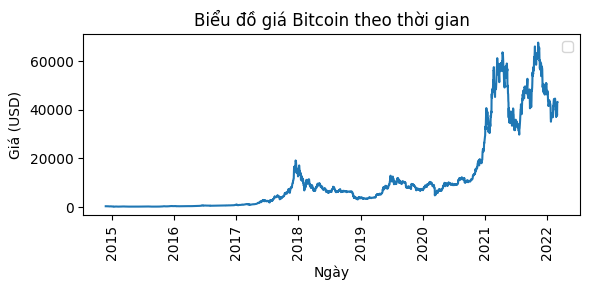

In [160]:
plt.figure(figsize=(6, 3))
plt.plot(df['Ngày'], df['Giá đóng'])
plt.title('Biểu đồ giá Bitcoin theo thời gian')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

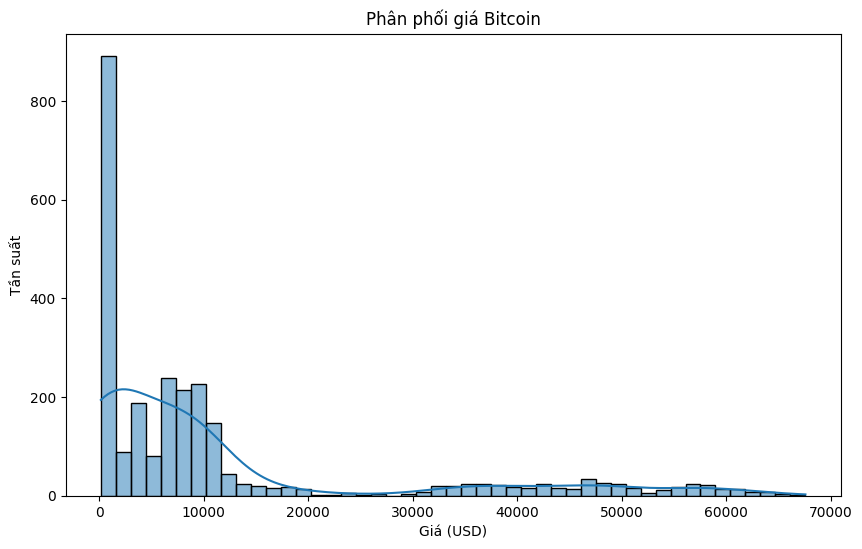

In [161]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Giá đóng'], kde=True)
plt.title('Phân phối giá Bitcoin')
plt.xlabel('Giá (USD)')
plt.ylabel('Tần suất')
plt.show()

In [162]:
prophet_df = df[['Ngày', 'Giá đóng']].rename(columns={'Ngày': 'ds', 'Giá đóng': 'y'})

In [163]:
train_size = int(len(prophet_df) * 0.8)
train_df = prophet_df[:train_size]
test_df = prophet_df[train_size:]

In [164]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(train_df)

15:07:03 - cmdstanpy - INFO - Chain [1] start processing
15:07:03 - cmdstanpy - INFO - Chain [1] done processing


In [169]:
future = model.make_future_dataframe(periods=len(test_df) + 3)
forecast = model.predict(future)

In [170]:
forecast_test = forecast[(forecast['ds'] >= test_df['ds'].min()) & (forecast['ds'] <= test_df['ds'].max())]
y_pred = forecast_test['yhat'].values
y_true = test_df['y'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"\nĐánh giá mô hình dự đoán:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")


Đánh giá mô hình dự đoán:
Mean Absolute Error: 30667.29
Root Mean Squared Error: 34109.29


In [171]:
import matplotlib.dates as mdates

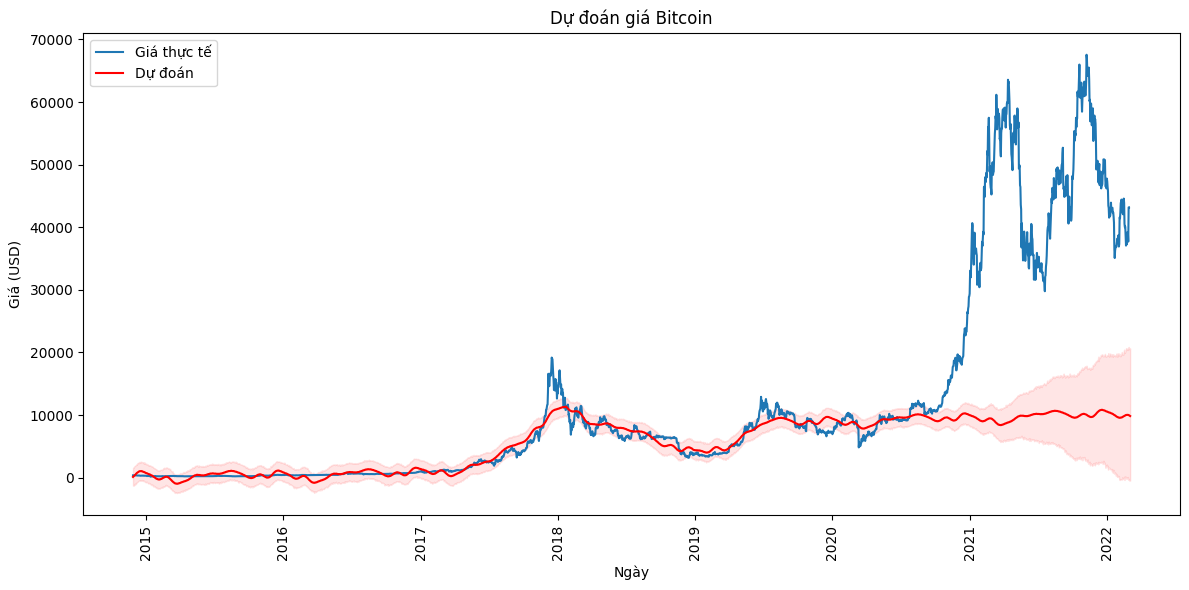

In [172]:
plt.figure(figsize=(12, 6))
plt.plot(df['Ngày'], df['Giá đóng'], label='Giá thực tế')
plt.plot(forecast['ds'], forecast['yhat'], label='Dự đoán', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1)

plt.title('Dự đoán giá Bitcoin')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [173]:
print("Ngày cuối cùng trong dữ liệu huấn luyện:", last_train_date)

Ngày cuối cùng trong dữ liệu huấn luyện: 2022-03-01 00:00:00


In [174]:
print(forecast[forecast['ds'] > last_train_date].head())

             ds         trend  yhat_lower    yhat_upper  trend_lower  \
2651 2022-03-02  10246.246058 -474.963048  20719.391522   110.282404   
2652 2022-03-03  10247.779802 -465.048311  20526.346405    96.702941   
2653 2022-03-04  10249.313547 -458.031992  20656.914571    47.576802   

       trend_upper  additive_terms  additive_terms_lower  \
2651  20789.862351     -302.503191           -302.503191   
2652  20812.401184     -369.771503           -369.771503   
2653  20834.940016     -399.060151           -399.060151   

      additive_terms_upper      daily  ...     weekly  weekly_lower  \
2651           -302.503191 -68.708063  ...   5.482216      5.482216   
2652           -369.771503 -68.708063  ... -19.895099    -19.895099   
2653           -399.060151 -68.708063  ...  -1.742265     -1.742265   

      weekly_upper      yearly  yearly_lower  yearly_upper  \
2651      5.482216 -239.277344   -239.277344   -239.277344   
2652    -19.895099 -281.168341   -281.168341   -281.168341   

In [175]:
last_train_date = prophet_df['ds'].max()

future_only = forecast[forecast['ds'] > last_train_date].head(3)

print("\nDự đoán giá Bitcoin trong 3 ngày tới:")
print("\nNgày\t\t\tTin cậy (USD)\tThấp nhất\tCao nhất")
print("-" * 80)
for _, row in future_only.iterrows():
    date = row['ds'].strftime('%d/%m/%Y')
    price = f"{row['yhat']:,.2f}"
    lower = f"{row['yhat_lower']:,.2f}"
    upper = f"{row['yhat_upper']:,.2f}"
    print(f"{date}\t{price:>15}\t{lower:>15} - {upper:>15}")



Dự đoán giá Bitcoin trong 3 ngày tới:

Ngày			Tin cậy (USD)	Thấp nhất	Cao nhất
--------------------------------------------------------------------------------
02/03/2022	       9,943.74	        -474.96 -       20,719.39
03/03/2022	       9,878.01	        -465.05 -       20,526.35
04/03/2022	       9,850.25	        -458.03 -       20,656.91
